In [21]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp

# from Classes import LEDparams

# Simple PID library https://github.com/m-lundberg/simple-pid/tree/master (Documentation: https://pypi.org/project/simple-pid/)
from simple_pid import PID

from scipy.linalg import solve_discrete_are

In [22]:
class LEDparams:
    def __init__(self) -> None:
        self.I_LED = 0.017 # A
        
        # TODO identify values
        radiant_power_dict = {
            'IR':       3.0,
            'Red':      4.0,
            'Orange':   4.0,
            'Green':    4.5,
            'Blue':     5.0,
            'Purple':   5.5,
            'UV':       6.0
        } # mW/cm^2

        # Convert to numpy array
        specific_radiant_power = np.array([radiant_power_dict[color] for color in radiant_power_dict.keys()]) # mW/cm^2

        # Single hole
        diameter = 7 # mm
        cross_section = np.pi * (diameter/10/2)**2 # cm^2
        self.radiant_power = cross_section * specific_radiant_power / 1000 # W

        # Dimensions for checking
        num_colors = len(specific_radiant_power)
        plate_row = 8
        plate_col = 12
        self.dimensions = (num_colors, plate_row, plate_col)

    def program_reader(self) -> np.ndarray:
        """ Returns the total duty cycle, single LED constant current and total radiant power"""
        x_matrix = np.random.randint(0, 2**16-1, self.dimensions) # TODO implement program reader

        x_matrix_scaled = x_matrix / (2**16-1) # duty cycle

        self.P_r = np.sum(x_matrix_scaled * self.radiant_power[:, np.newaxis, np.newaxis]) # W

        self.x_LED_tot = np.sum(x_matrix_scaled) # total duty cycle assuming equal current for all LEDs

        return self.x_LED_tot, self.I_LED, self.P_r

In [23]:
class Model:
    def __init__(self, LEDparams:LEDparams, x0:np.ndarray, T_amb0:float=42.0) -> None:
        """
        x0 : Initial state

        u1: current through the peltier module
        u2: PWM fan

        x1: SoC
        x2: T_HP_c
        x3: T_HP_h
        """
        # State input initialization
        self.x = x0
        self.u = np.array([0.0, 0.0])

        # Parameters initialization
        self._init_params(LEDparams, x0, T_amb0)

        # Operational point initialization
        self._init_operational_point()

        # Symbolic initialization
        self._init_sym_model()

        # Dictionary to connect symbolic variables with values
        self.params_values = {
            'Q_max':        self.Q_BT_max, # Battery
            'R_in':         self.R_BT_int,
            'P_rest':       self.P_el_rest,
            'a3':           self.BT_coefs[0],
            'a2':           self.BT_coefs[1],
            'a1':           self.BT_coefs[2],
            'a0':           self.BT_coefs[3],
            'U_FAN':        self.U_FAN, # Fan
            'I_FAN':        self.I_FAN,
            'I_LED':        self.I_LED, # LED
            'x_LED':        self.x_LED,
            'P_r':          self.P_LED_r,
            'S_M':          self.S_M, # HP
            'R_M':          self.R_M,
            'K_M':          self.K_M,
            'x_HP':         self.x_HP,
            'c_p':          self.cp_Al, # Thermal
            'T_amb':        self.T_amb,
            'R3_lambda':    self.R_3_lambda,
            'm_c':          self.m_top_Al,
            'm_h':          self.m_bottom_Al,
            'R_eq':         (self.R_floor_lambda * self.R_air_alpha) / (self.R_floor_lambda + self.R_air_alpha),
            'R4_lambda':    self.R_4_lambda,
            'R5':           self.R_5,
        }

    def _init_params(self, LEDparams:LEDparams, x0:np.ndarray, T_amb0:float) -> None:
        # Battery parameters TODO insert 2 batteries
        self.P_el_rest = 2.0 # W TODO get better value
        self.Q_BT_max = 3.0 * 3600 # As (Ah = 3600 As)
        self.R_BT_int = 0.1 # Ohm
        self.BT_coefs = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Battery\\battery_fitted_coefficients_3rd.csv'
            ).to_numpy().flatten()
        self.U_BT_oc = self.voltage_soc(x0[0]) # V

        # Fan parameters
        self.I_FAN = 0.13 # A
        self.U_FAN = 12.0 # V
        self.R_air_alpha = 1.0 # K/W # TODO change to a function of the fan PWM

        # LED parameters
        self.I_LED = LEDparams.I_LED # A
        self.x_LED = LEDparams.x_LED_tot # duty cycle
        self.P_LED_r = LEDparams.P_r # W

        # Thermal parameters
        self.T_amb = conv_temp(T_amb0, 'C', 'K') # K
        self.cp_Al = 897.0 # J/kgK https://en.wikipedia.org/wiki/6061_aluminium_alloy
        # self.cp_air = 1006.0 # J/kgK https://www.engineeringtoolbox.com/air-specific-heat-capacity-d_705.html?vA=37&degree=C&pressure=1bar#

        # Top thermal parameters - Diffuser
        # TODO estimation of parameters
        self.R_3_lambda = 0.1 # K/W
        self.R_4_lambda = 5.0 # K/W
        self.R_5 = 25.0 # K/W

        # Top Al thermal parameters
        self.m_top_Al = 0.0638 # kg

        # Bottom Al thermal parameters - Heat sink
        self.m_bottom_Al = 0.0876 # kg
        self.R_floor_lambda = 10 # K/W # TODO estimated real time

        # Heat pump - peltier module
        HP_params = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Heat Pump\\HP_fitted_coefficients.csv'
            )
        self.I_HP_max = HP_params["I_max"].iloc[0] # A
        self.R_M = HP_params["R_M"].iloc[0] # Ohm
        self.S_M = HP_params["S_M"].iloc[0] # V/K
        self.K_M = HP_params["K_M"].iloc[0] # W/K
        self.x_HP = 0.5 # duty cycle # TODO change to a function of the heat pump?

    def _init_operational_point(self) -> None:
        x_SoC = 0.85
        T_c = conv_temp(25.0, 'C', 'K') # K # TODO bring it as a function of T_amb?
        T_h = conv_temp(55.0, 'C', 'K') # K # TODO bring it as a function of T_amb?
        I_HP = 1.2 # A
        x_FAN = 1.0 # duty cycle

        self.x_op = np.array([x_SoC, T_c, T_h])
        self.u_op = np.array([I_HP, x_FAN])

    def _init_sym_model(self) -> None:
        # State variables
        x_SoC, T_c, T_h = sp.symbols('x_SoC, T_c, T_h')
        self.sym_x      = sp.Matrix([x_SoC, T_c, T_h])

        # Input variables
        I_HP, x_FAN = sp.symbols('I_HP, x_FAN')
        self.sym_u  = sp.Matrix([I_HP, x_FAN])

        # Battery parameters
        Q_max, R_in, P_rest = sp.symbols('Q_max, R_in, P_rest')
        a3, a2, a1, a0 = sp.symbols('a3, a2, a1, a0')
        U_oc = a3 * x_SoC**3 + a2 * x_SoC**2 + a1 * x_SoC + a0

        # Fan parameters
        U_FAN, I_FAN = sp.symbols('U_FAN, I_FAN')

        # LED parameters
        I_LED, x_LED, P_r = sp.symbols('I_LED, x_LED, P_r')

        # HP parameters - Peltier module
        S_M, R_M, K_M, x_HP = sp.symbols('S_M, R_M, K_M, x_HP')

        # Thermal parameters
        c_p, T_amb = sp.symbols('c_p, T_amb')

        # Top thermal parameters - Diffuser
        R3_lambda = sp.symbols('R3_lambda')

        # Top Al thermal parameters - Diffuser
        m_c = sp.symbols('m_c')

        # Bottom Al thermal parameters - Heat sink
        m_h, R_eq = sp.symbols('m_h, R_eq') # TODO change R_eq to its expression

        # Output: I_BT
        I_BT = U_oc + R_in * x_HP * I_HP + R_in * I_LED * x_LED - sp.sqrt(U_oc**2 - 2 * R_in * I_LED * x_LED * U_oc - 2 * R_in * x_HP * U_oc * I_HP + (R_in * x_HP)**2 * I_HP**2 + 2 * R_in * I_LED * x_LED * R_in * x_HP * I_HP - 4 * R_in * I_FAN * U_FAN * x_FAN - 4 * R_in * P_rest + (R_in * I_LED * x_LED)**2)
        
        # LED calculation
        U_BT = U_oc - R_in * I_BT
        P_LED = I_LED * U_BT * x_LED
        Q_LED = P_LED - P_r

        # Top thermal
        R4_lambda, R5 = sp.symbols('R4_lambda, R5')
        RHS = sp.Matrix([Q_LED,
                        0,
                        0,
                        -T_c,
                        0,
                        -T_amb
        ])
        matrix = sp.Matrix([
            [1,         1,          0,    0,  0,  0],
            [1,         0,         -1,    0,  0,  0],
            [0,         1,          0,   -1,  0,  0],
            [0,         R3_lambda,  0,    0, -1,  0],
            [R4_lambda, 0,          0,    0, -1,  1],
            [0,         0,          R5,   0,  0, -1]
        ])
        var_top_thermal = matrix.LUsolve(RHS)

        # Output: T_cell
        T_LED = var_top_thermal[4] # K
        T_cell = var_top_thermal[5] # K

        # Nonlinear ODEs
        dTh_dt = (1 / (m_h * c_p)) * (S_M * I_HP * T_c - (R_in + 0.5 * R_M) * I_HP**2 - K_M * T_h + K_M * T_c + U_oc * I_HP - R_in * (I_FAN + I_LED) * I_HP + T_amb / R_eq - T_h / R_eq)
        dTc_dt = (1 / (m_c * c_p)) * (T_LED / R3_lambda - (1 / R3_lambda + K_M) * T_c - S_M * I_HP * T_c + 0.5 * R_M * I_HP**2 + K_M * T_h)
        dxSoC_dt = I_BT / (-2 * Q_max * R_in)

        # Symbolic dynamics
        self.f_symb = sp.Matrix([dxSoC_dt, dTc_dt, dTh_dt])

        # Symbolic output
        self.g_symb = sp.Matrix([T_cell, I_BT])

        # Symbolic linearization
        self.A_symb = self.f_symb.jacobian(self.sym_x)
        self.B_symb = self.f_symb.jacobian(self.sym_u)
        self.C_symb = self.g_symb.jacobian(self.sym_x)
        self.D_symb = self.g_symb.jacobian(self.sym_u)

    def _get_dict(self, x:np.ndarray, u:np.ndarray) -> dict:
        x_symb = sp.Matrix(x)
        u_symb = sp.Matrix(u)
        state_values = {self.sym_x[i]: x_symb[i] for i in range(len(self.sym_x))}
        input_values = {self.sym_u[i]: u_symb[i] for i in range(len(self.sym_u))}

        return state_values, input_values

    def get_linearization(self, xss:np.ndarray=None, uss:np.ndarray=None) -> np.ndarray:
        if xss is None:
            xss = self.x_op
        if uss is None:
            uss = self.u_op

        state_values, input_values = self._get_dict(xss, uss)

        A = self.A_symb.subs(self.params_values).subs(state_values).subs(input_values)
        B = self.B_symb.subs(self.params_values).subs(state_values).subs(input_values)
        h = self.f_symb.subs(self.params_values).subs(state_values).subs(input_values)

        C = self.C_symb.subs(self.params_values).subs(state_values).subs(input_values)
        D = self.D_symb.subs(self.params_values).subs(state_values).subs(input_values)
        l = self.g_symb.subs(self.params_values).subs(state_values).subs(input_values)

        return np.array(A).astype(np.float64), np.array(B).astype(np.float64), np.array(h).astype(np.float64), np.array(C).astype(np.float64), np.array(D).astype(np.float64), np.array(l).astype(np.float64)
    
    def dynamics_f(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        state_values, input_values = self._get_dict(x, u)

        f = self.f_symb.subs(self.params_values).subs(state_values).subs(input_values)
        
        return np.array(f).astype(np.float64).reshape(-1)
    
    def observer_g(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        state_values, input_values = self._get_dict(x, u)

        g = self.g_symb.subs(self.params_values).subs(state_values).subs(input_values)

        return np.array(g).astype(np.float64).reshape(-1)

    def discretized_update(self, u:np.ndarray, dt:float) -> np.ndarray:
        """
        Update the states using RK4 integration.
        """
        x = self.x

        # Runge-Kutta 4th order
        k1 = self.dynamics_f(x, u)
        k2 = self.dynamics_f(x + 0.5 * dt * k1, u)
        k3 = self.dynamics_f(x + 0.5 * dt * k2, u)
        k4 = self.dynamics_f(x + dt * k3, u)

        self.x = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        self.u = u
        return self.x
    
    def get_output(self) -> np.ndarray:
        return self.observer_g(self.x, self.u)
    
    def voltage_soc(self, SoC) -> float:
        return np.polyval(self.BT_coefs, SoC)


class PIDController:
    def __init__(self, kp:float, ki:float, kd:float, setpoint:float, dt:float, output_limits:tuple) -> None:
        self.pid = PID(Kp=kp, Ki=ki, Kd=kd, setpoint=setpoint, sample_time=dt, output_limits=output_limits)

    def get_control_input(self, current_output) -> np.ndarray:
        u_HP = self.pid(current_output)

        u_FAN = 1.0 # TODO change to MIMO
        return np.array([u_HP, u_FAN])


class LQRController:
    """ Infinite horizon LQR controller """
    def __init__(self, A:np.ndarray, B:np.ndarray, Q:np.ndarray, R:np.ndarray) -> None:
        # TODO check dimensions and properties of Q and R
        self.P = solve_discrete_are(A, B, Q, R)
        self.K = -np.linalg.inv(R + B.T @ self.P @ B) @ B.T @ self.P @ A

    def get_control_input(self, current_state) -> np.ndarray:
        return self.K @ current_state


class Simulation:
    def __init__(self, model, controller, dt, time_span) -> None:
        self.model = model
        self.controller = controller
        self.dt = dt
        self.time_span = time_span

    def run(self) -> pd.DataFrame:
        time_steps = int(self.time_span / self.dt)
        
        data = {
            "time": [],
            "SoC": [],
            "T_HP_c": [],
            "T_HP_h": [],
            "T_cell": []
        }

        for t in range(time_steps):
            current_time = t * self.dt

            current_output = self.model.get_output() # TODO change to MIMO, for minimizing battery power consumption

            # Get control input from the controller
            u = self.controller.get_control_input(current_output[0])

            # Advance system states
            x = self.model.discretized_update(u, self.dt)

            # Get output
            y = self.model.get_output()

            data["time"].append(current_time)
            data["SoC"].append(x[0])
            data["T_HP_c"].append(x[1])
            data["T_HP_h"].append(x[2])
            data["T_cell"].append(y[0])

        return pd.DataFrame(data)

In [24]:
LEDparams = LEDparams()
LEDparams.program_reader()

# Initial conditions
x0 = np.array([0.9, conv_temp(39.0, 'C', 'K'), conv_temp(39.0, 'C', 'K')])
T_amb0 = 42.0 # C

model = Model(LEDparams, x0, T_amb0=T_amb0)

dt = 10
time_span = 100

kp, ki, kd = 1, 1, 0.0
setpoint = conv_temp(37.0, 'C', 'K') # K
output_limits = (0.0, model.I_HP_max) # A # TODO enable negative current
controller = PIDController(kp, ki, kd, setpoint, dt, output_limits)

A, B, h, C, D, l = model.get_linearization()
Q = np.eye(A.shape[0])
R = np.eye(B.shape[1])
# controller = LQRController(A, B, Q, R)

sim = Simulation(model, controller, dt, time_span)

# Run the simulation
results = sim.run()

# Efficient vectorized conversion
results[["T_cell", "T_HP_c", "T_HP_h"]] = conv_temp(results[["T_cell", "T_HP_c", "T_HP_h"]].to_numpy(), 'K', 'C')

<Figure size 1200x400 with 0 Axes>

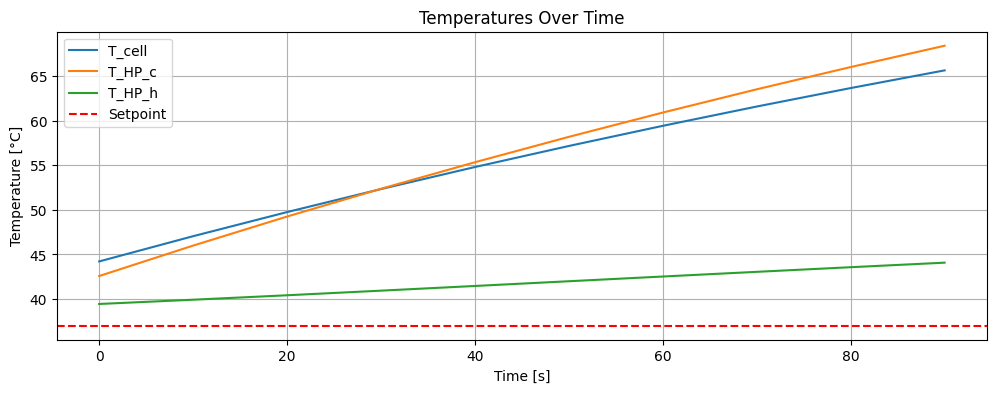

<Figure size 1200x400 with 0 Axes>

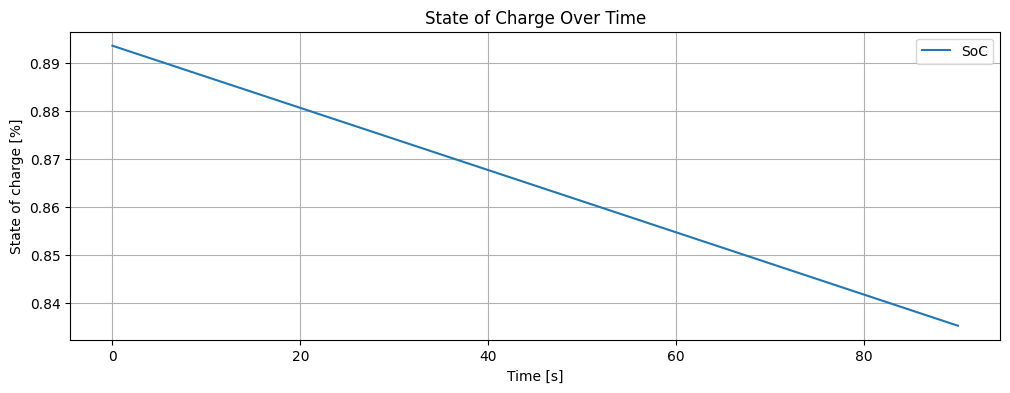

In [25]:
# Plot
plt.figure(figsize=(12, 4))
ax = results.plot(
    x="time", 
    y=["T_cell", "T_HP_c", "T_HP_h"], 
    xlabel="Time [s]", 
    ylabel="Temperature [°C]", 
    title="Temperatures Over Time",
    figsize=(12, 4),
)
ax.axhline(
    y=conv_temp(setpoint, 'K', 'C'), 
    color='r', 
    linestyle='--', 
    label='Setpoint'
)
plt.legend()
plt.grid()
plt.show()

# Plot
plt.figure(figsize=(12, 4))
ax = results.plot(
    x="time", 
    y=["SoC"], 
    xlabel="Time [s]", 
    ylabel="State of charge [%]", 
    title="State of Charge Over Time",
    figsize=(12, 4),
)
plt.legend()
plt.grid()
plt.show()
